### <span style="color: #FF9800;"> File overview </span> ###

This notebook implements a stacking model for subreddit prediction. The stacking classifier combines the predictions of multiple models, including Support Vector Machines (SVM) and Bernoulli Naive Bayes (BNB). Hyperparameter tuning is performed, and the model's performance is evaluated using 10-fold cross-validation.

### <span style="color: #FF9800;"> Load modules </span> ###

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=UserWarning)  # This will suppress UserWarnings

import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import confusion_matrix

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, words

# Ensure required NLTK resources are downloaded
try:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('words')

except Exception as e:
    print(f"Error downloading NLTK resources: {e}")

# Define stopwords list
specific_stopwords = ["https", "subreddit", "www", "com"] ## some specific words for the given dataset
stopwords_list = stopwords.words('english') +specific_stopwords + stopwords.words('french') # dataset is both in english and in french

[nltk_data] Downloading package punkt to /home/clatimie/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/clatimie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /home/clatimie/nltk_data...
[nltk_data]   Package words is already up-to-date!


### <span style="color: #FF9800;"> Load training dataset </span> ###

In [ ]:
# Define the path to the training data file
path_training = "../datasets/Train.csv"

# Read the CSV file into a pandas DataFrame
training_data = pd.read_csv(path_training, delimiter=',')

# Set column names explicitly for better readability
training_data.columns = ['text', 'subreddit']

# Shuffle dataset
training_data = training_data.sample(frac=1, random_state=42).reset_index(drop=True) 

# Separate the training data into two series: texts and subreddit labels
x_train = training_data['text']          # Contains the Reddit posts or comments
y_train = training_data['subreddit'] # Contains the subreddit each post originates from

# Get unique subreddit labels
unique_labels = np.unique(y_train)   # List of unique subreddits in the dataset

n_samples_trainings = x_train.shape[0]
n_classes = unique_labels.shape[0]

print(f"Training dataset has {n_samples_training} examples and there are {n_classes} classes")

Training dataset has 1399 examples and there are 4 classes


### <span style="color: #FF9800;"> LOad test dataset </span> ###

In [3]:
# Define the path to the training data file
path_test = "../datasets/Test.csv"

# Read the CSV file into a pandas DataFrame
x_test = pd.read_csv(path_test, delimiter=',')["body"]

n_samples_test = x_test.shape[0]
print(f"Test dataset has {n_samples_test} examples")


Test dataset has 600 examples


### <span style="color: #FF9800;"> Lemma Tokenizer from NLTK </span> ###

In [4]:
class LemmaTokenizer:
    def __init__(self, stopwords=None):
        self.wnl = WordNetLemmatizer()
        self.stop_words = stopwords

    def __call__(self, doc):
        # Tokenize the document and apply lemmatization and filtering
        return [
            self.wnl.lemmatize(t, pos="v") for t in word_tokenize(doc)
            if t.isalpha() and t.lower() not in self.stop_words]

### <span style="color: #FF9800;"> 10 fold cross validation of the stacking model </span> ###

Classification Report:
               precision    recall  f1-score   support

    Brussels       0.79      0.79      0.79        38
      London       0.62      0.88      0.73        32
    Montreal       0.83      0.75      0.79        32
     Toronto       0.89      0.66      0.76        38

    accuracy                           0.76       140
   macro avg       0.78      0.77      0.77       140
weighted avg       0.79      0.76      0.77       140

Validation accuracy for fold 1: 0.7643
Training accuracy for fold 1: 0.9333

Classification Report:
               precision    recall  f1-score   support

    Brussels       0.82      0.76      0.79        37
      London       0.62      0.86      0.72        36
    Montreal       1.00      0.82      0.90        28
     Toronto       0.88      0.74      0.81        39

    accuracy                           0.79       140
   macro avg       0.83      0.80      0.80       140
weighted avg       0.82      0.79      0.80       140

Valid

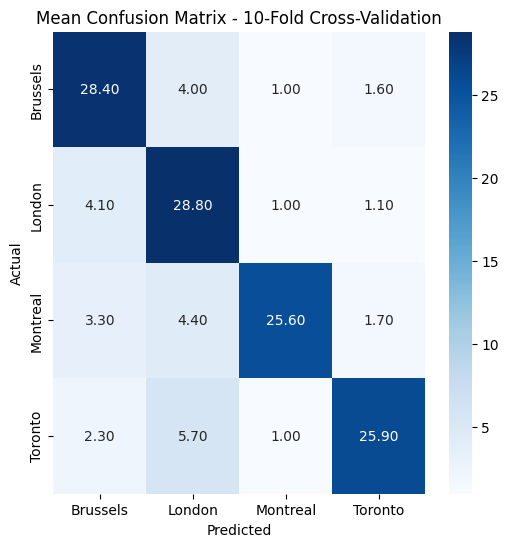

Mean Accuracy across 10 folds: 0.7770
Mean Accuracy across 10 folds: 0.9365

Average Accuracy per Class:
Class Toronto: 0.8547
Class Montreal: 0.9025
Class London: 0.6739
Class Brussels: 0.7502
Computing time : 105.14465403556824 (s)


In [5]:
y_binary = [1 if label == "Montreal" else -1 for label in y_train] # for svm training

# Define vectorizers
vectorizer_svm = TfidfVectorizer(lowercase=True, tokenizer=LemmaTokenizer(stopwords=stopwords_list), strip_accents="unicode")
vectorizer_bnb = CountVectorizer(lowercase=True, tokenizer=LemmaTokenizer(stopwords=stopwords_list), strip_accents="unicode")

# Define models
svm_model = SVC(kernel='rbf', probability=True, gamma='scale', C=1)
bnb_model = BernoulliNB()

# Define feature selectors
selector_bnb = SelectKBest(mutual_info_classif, k=2850)
selector_svm = SelectKBest(mutual_info_classif, k=3000)

# Define scaler 
scaler_svm = StandardScaler()

# Preprocess data before cross-validation
X_train_bnb = vectorizer_bnb.fit_transform(x_train)
X_train_svm = vectorizer_svm.fit_transform(x_train)

# Apply feature selection
X_train_bnb_selected = selector_bnb.fit_transform(X_train_bnb, y_train)
X_train_svm_selected = selector_svm.fit_transform(X_train_svm, y_binary)

# Scale the SVM features
X_train_svm_scaled = scaler_svm.fit_transform(np.asarray(X_train_svm_selected.todense()))

# Prepare KFold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

accuracies = []
training_accuracies = []
class_accuracies = {class_name: [] for class_name in set(y_train)}  # To store accuracy for each class

mean_conf_matrix = np.zeros((len(np.unique(y_train)), len(np.unique(y_train))))  # Initialize empty confusion matrix

fold = 0

# 10-Fold Cross-Validation
time_start = time.time()
for train_index, val_index in kf.split(X_train_svm_scaled):
    fold += 1
    # Split data into training and validation sets
    X_train_fold_svm, X_val_fold_svm = X_train_svm_scaled[train_index], X_train_svm_scaled[val_index]
    X_train_fold_bnb, X_val_fold_bnb = X_train_bnb_selected[train_index], X_train_bnb_selected[val_index]
    y_train_bnb_fold, y_val_bnb_fold = np.array(y_train)[train_index], np.array(y_train)[val_index]
    y_train_svm_fold, y_val_svm_fold = np.array(y_binary)[train_index], np.array(y_binary)[val_index]

    # Train the models
    svm_model.fit(X_train_fold_svm, y_train_svm_fold)
    bnb_model.fit(X_train_fold_bnb, y_train_bnb_fold)
    
    # Get predictions from both models
    svm_predictions = svm_model.predict(X_val_fold_svm)
    bnb_predictions = bnb_model.predict(X_val_fold_bnb)
    
    # Vectorized version of combining predictions
    final_predictions = np.where(svm_predictions == 1, "Montreal", bnb_predictions)

    # Get predictions from both models for training data
    svm_predictions_training = svm_model.predict(X_train_fold_svm)
    bnb_predictions_training = bnb_model.predict(X_train_fold_bnb)
    
    # Vectorized version of combining predictions for training data
    final_predictions_training = np.where(svm_predictions_training == 1, "Montreal", bnb_predictions_training)

    # Calculate accuracy for this fold
    accuracy = accuracy_score(y_val_bnb_fold, final_predictions)  # Use y_val_bnb_fold as the correct target variable
    accuracies.append(accuracy)

    training_accuracy  = accuracy_score(y_train_bnb_fold, final_predictions_training)
    training_accuracies.append(training_accuracy)

    print("Classification Report:\n", classification_report(y_val_bnb_fold, final_predictions))
    class_accuracy = classification_report(y_val_bnb_fold, final_predictions, output_dict=True)

    for label, metrics in class_accuracy.items():
        if label != 'accuracy' and label != "macro avg" and label != "weighted avg": 
            class_accuracies[label].append(metrics['precision'])

    print(f"Validation accuracy for fold {fold}: {accuracy:.4f}")
    print(f"Training accuracy for fold {fold}: {training_accuracy:.4f}\n")

    # Confusion Matrix for this fold
    conf_matrix = confusion_matrix(y_val_bnb_fold, final_predictions)

    # Add this fold's confusion matrix to the cumulative confusion matrix
    mean_conf_matrix += conf_matrix
time_end = time.time()
# Calculate the mean confusion matrix
mean_conf_matrix /= kf.get_n_splits()  # Average the confusion matrix

# Plot the mean confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(mean_conf_matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.title("Mean Confusion Matrix - 10-Fold Cross-Validation")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Calculate the mean accuracy across all folds
mean_accuracy = np.mean(accuracies)
print(f"Mean Accuracy across 10 folds: {mean_accuracy:.4f}")

mean_training_accuracy = np.mean(training_accuracies)
print(f"Mean Accuracy across 10 folds: {mean_training_accuracy:.4f}")

# Average accuracy for each class
print("\nAverage Accuracy per Class:")
for label, accuracies in class_accuracies.items():
    avg_class_accuracy = np.mean(accuracies)
    print(f"Class {label}: {avg_class_accuracy:.4f}")

print(f"Computing time : {time_end-time_start} (s)")

# Fitting the models with the whole dataset
svm_model.fit(X_train_svm_scaled, y_binary)
bnb_model.fit(X_train_bnb_selected, y_train)

# Preprocess x_test
x_test_bnb = vectorizer_bnb.transform(x_test)
x_test_svm = vectorizer_svm.transform(x_test)

x_test_bnb_selected = selector_bnb.transform(x_test_bnb)
x_test_svm_selected = selector_svm.transform(x_test_svm)

x_test_svm_scaled = scaler_svm.transform(np.asarray(x_test_svm_selected.todense()))

# Make predictions
svm_predictions = svm_model.predict(x_test_svm_scaled)
bnb_predictions = bnb_model.predict(x_test_bnb_selected)
final_predictions = []
final_predictions = np.where(svm_predictions == 1, "Montreal", bnb_predictions)


results_df = pd.DataFrame({
    'id': range(len(final_predictions)),
    'subreddit': final_predictions
})

results_df.to_csv("../output/stacking.csv", index=False)


